# Regularized martingale OT using generalized iterative scaling (GIS)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import squareform, pdist, cdist
from scipy.optimize import linprog

In [2]:
np.set_printoptions(suppress=True, precision=5)

## Generate data

In [3]:
M = 100
x = np.linspace(-1.0, 1.0, M)

In [4]:
# gaussians
scale = 0.2
translate = 0.3
mu = norm(loc=0.0, scale=scale).pdf(x)
mu /= mu.sum()
nu = 0.5*(norm(loc=-translate, scale=scale).pdf(x) + norm(loc=translate, scale=scale).pdf(x))
nu /= nu.sum()

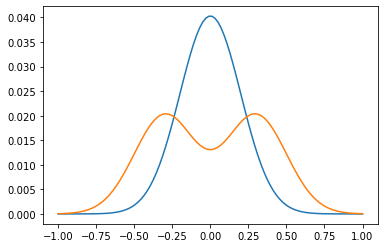

In [5]:
plt.plot(x, mu)
plt.plot(x, nu)

## Solve using LP

In [6]:
mu_constraints = np.stack([np.tile(x[:, None], reps=(1, M)).flatten() for x in np.eye(M)])
nu_constraints = np.stack([np.tile(x[None, :], reps=(M, 1)).flatten() for x in np.eye(M)])

mart_constraints = []
for i in range(M):
    constr = np.zeros((M, M))
    constr[i] = x
    mart_constraints.append(constr.flatten())
mart_constraints = np.stack(mart_constraints)

In [7]:
mu_constraints.shape

(100, 10000)

In [8]:
A_eq = np.concatenate([mu_constraints, nu_constraints, mart_constraints], axis=0)
b_eq = np.concatenate([mu, nu, mu*x])

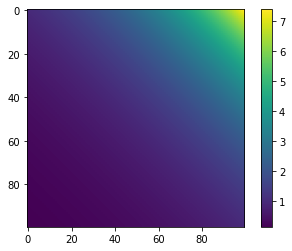

In [9]:
c = np.exp(x[None]-x[:, None])
plt.imshow(c)
plt.colorbar()

In [10]:
%%time
res = linprog(c.flatten(), A_eq=A_eq, b_eq=b_eq)
res.message

/home/johannes/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  """Entry point for launching an IPython kernel.
/home/johannes/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  """Entry point for launching an IPython kernel.
/home/johannes/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  """Entry point for launching an IPy

CPU times: user 6min 31s, sys: 1min 11s, total: 7min 43s
Wall time: 1min 10s


In [11]:
pi_lp = res.x.reshape((M, M))

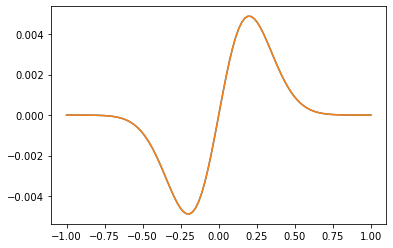

In [12]:
# check whether martingale constraints are fulfilled
plt.plot(x, pi_lp.dot(x))
plt.plot(x, mu*x)

## Solve using GIS

In [13]:
%%time

eps = 0.002
K = np.exp(-c/eps)

n_iter_max = int(1e5)
err_thres = 1e-5
it = 0
err = np.inf
pi = K.copy()

# prepare A
delta = 1e-5 # for numerical reasons
A = x - x.min() + delta
A /= A.max()*(1+delta)
A = np.stack([A, 1-A], axis=0)

while it < n_iter_max and err > err_thres:
    
    # nu constraint
    pi = pi * (nu / pi.sum(axis=0))[None, :]

    # martingale constraints on normalized pi
    pi = pi * np.exp(np.log(A.T / pi.dot(A.T)).dot(A))

    # mu constraint
    pi = pi * (mu / pi.sum(axis=1))[:, None]
    
    # convergence management - constraint violation
    err = np.abs(np.concatenate([
        pi.sum(axis=1) - mu,
        pi.sum(axis=0) - nu,
        pi.dot(x) - mu*x,
    ])).max()
    it += 1

print(f"Converged after {it} iterations.")

Converged after 1467 iterations.
CPU times: user 4.88 s, sys: 4.6 s, total: 9.48 s
Wall time: 1.39 s


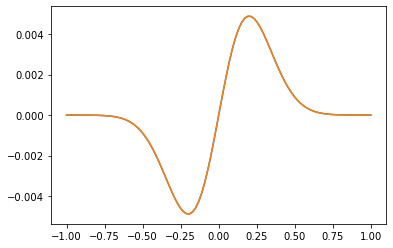

In [14]:
# check whether martingale constraints are fulfilled
plt.plot(x, pi.dot(x))
plt.plot(x, mu*x)

## Comparison

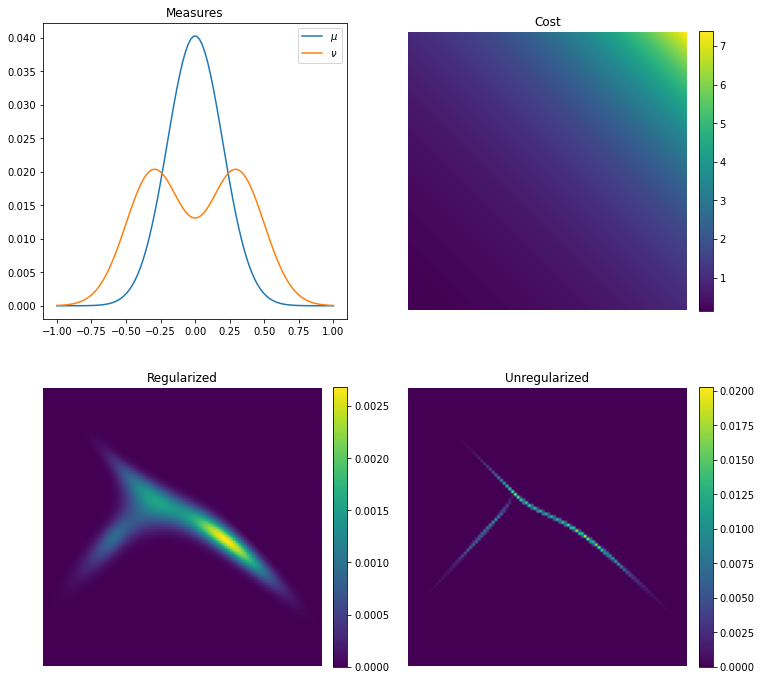

In [15]:
# make this one figure
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# measures
ax[0, 0].plot(x, mu, label=r'$\mu$')
ax[0, 0].plot(x, nu, label=r'$\nu$')
ax[0, 0].legend()
ax[0, 0].title.set_text('Measures')

# costs
h = ax[0, 1].imshow(c)
fig.colorbar(h, fraction=0.046, pad=0.04, ax=ax[0, 1])
ax[0, 1].set_axis_off()
ax[0, 1].title.set_text('Cost')

# plans
plans = [pi, pi_lp]
subtitles = ['Regularized', 'Unregularized']
for i, (plan, title) in enumerate(zip(plans, subtitles)):
    h = ax[1, i].imshow(plan)
    fig.colorbar(h, fraction=0.046, pad=0.04, ax=ax[1, i])
    ax[1, i].set_axis_off()
    ax[1, i].title.set_text(title)